## Reddit Philippines Random Discussion Threads: A Just-for-fun Exploration

Having been inactive on Facebook for quite some time now, I've turned to the [Philippines subreddit](https://www.reddit.com/r/Philippines/) for my periodic dose of local fun stuff. The sub itself has many interesting posts, though I have noticed some complaints about it being too political lately. (Reddit is accused of being partial to one side, and to confirm that is another interesting story.) Mostly 'spared' from political posts is the Random Discussion thread. An RD is generally a mix of rants, jokes, what-i-did-today, what-did-you-eat, and please-help-me type of posts, like a Facebook feed of people you don't know - with less selfies. (There are selfie threads occasionally.) Soon, it would be four years since the first RD, so I thought, why not look back and explore the data? Churn out some statistics for awards of some virtual sort, or maybe even learn how something becomes meme status. This won't change the world or anything, just fun practice.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
#from plotly.offline import iplot, init_notebook_mode
#import plotly.graph_objs as go

#import sys
import os
from datetime import datetime, date, time, timedelta

import praw
from prawcore.exceptions import RequestException
import pprint

import logging

sns.set_style("white")
pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",200)
#init_notebook_mode(connected=True)
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore


Good thing there's a Python wrapper for the Reddit API that makes data extraction easier. Import configuration file that contains settings (see [PRAW docs](http://praw.readthedocs.io/en/latest/getting_started/authentication.html#oauth) for instructions)

In [2]:
import credentials

reddit = praw.Reddit(client_id = credentials.reddit['CLIENT_ID'],
                     client_secret = credentials.reddit['CLIENT_SECRET'],
                     user_agent = credentials.reddit['USER_AGENT'])

A preliminary search revealed that the first RD was posted 2014-03-12. We'll use this to limit our search horizon. 

In [3]:
inception =  datetime(2014, 3, 12)
today = datetime.today()
today_beginning = datetime.combine(date.today(), time())
print(today_beginning)

2018-03-17 00:00:00


We then define a function that specifies the information we'd like to extract for a submission (i.e. the RD thread). For some reason, downs are always 0 and score = ups so we don't include ups and downs anymore. 

In [4]:
def add_submission (submission):
    """ 
        Extracts selected information about a Reddit submission (thread).
            submission: PRAW submission object
        returns DICT
    """

    addl_submission = {'id':str(submission.id),
                       #'submission':submission,
                       'title':submission.title,
                       'author':submission.author,
                       'created': submission.created,
                       'permalink':submission.permalink,
                       'n_comments':submission.num_comments,
                       'score':submission.score
                       #'ups':reddit.submission(id=sub_id).ups,
                       #'downs':reddit.submission(id=sub_id).downs
    }
    
    return addl_submission

In [5]:
submissions_file = 'submissionsDF.csv'
comments_file = 'commentsDF.csv'

The idea is to save a submissions data file locally so we don't have to download the data each time. We search for submissions with the string "random discussion" the first time to get the bulk of the data and update incrementally if we want to. (A daily update should yield 4 submissions in the search - those from yesterday.)

In [6]:
if os.path.isfile(submissions_file):
    with open(submissions_file, 'r') as f:
        submissionsDF = pd.read_csv(f, lineterminator='\n', converters={'id': lambda x: str(x)}) #ensure id is read as string
        search_start_date = pd.to_datetime(submissionsDF['created'], unit = 's').dt.date.max()
        search_start = datetime.combine(search_start_date, time())
        print('Old submissions file found. Will start search from {}'.format(search_start))
    
else:
    submissionsDF = pd.DataFrame()
    search_start = inception
    print('No submissions file found. Will start search from {}'.format(search_start))

# From PRAW docs:
# The value of submission.num_comments may not match up 100% with the number of comments extracted via PRAW. 
# This discrepancy is normal as that count includes deleted, removed, and spam comments.

search_terms = "random discussion"
print('Searching for \'{}\' between {} and {}'.format(search_terms,
                                                      search_start,
                                                     today_beginning
                                                     )
     )


new_submissions = [add_submission(submission)                       
               for submission in reddit.subreddit('Philippines').submissions(start = search_start.timestamp(), 
                                                                              end = today_beginning.timestamp(), 
                                                                              extra_query = '(or title:\'{}\')'.format(search_terms))]
print('Done.')

new_submissionsDF = pd.DataFrame(new_submissions)

submissionsDF = pd.concat([new_submissionsDF, submissionsDF])
submissionsDF = submissionsDF[~submissionsDF['id'].duplicated()]
submissionsDF = submissionsDF.set_index('id')
submissionsDF.to_csv(submissions_file)

submissionsDF['date'] = pd.to_datetime(submissionsDF['created'],unit='s').dt.date
print('Number of rows from search: {}'.format(new_submissionsDF.shape[0]))
print('Total number of submissions: {}'.format(submissionsDF.shape[0]))
submissionsDF.head()

Old submissions file found. Will start search from 2018-03-15 00:00:00
Searching for 'random discussion' between 2018-03-15 00:00:00 and 2018-03-17 00:00:00
Done.
Number of rows from search: 8
Total number of submissions: 3407


,author,created,n_comments,permalink,score,title,date
id,,,,,,,
84wgs5,the_yaya,1.521245e+09,289,/r/Philippines/comments/84wgs5/nightly_random_...,11,"Nightly random discussion - Mar 16, 2018",2018-03-16
84u9vi,the_yaya,1.521223e+09,1453,/r/Philippines/comments/84u9vi/evening_random_...,31,"Evening random discussion - Mar 16, 2018",2018-03-16
84sof4,the_yaya,1.521201e+09,1461,/r/Philippines/comments/84sof4/afternoon_rando...,24,"Afternoon random discussion - Mar 16, 2018",2018-03-16
84qcrj,the_yaya,1.521180e+09,2076,/r/Philippines/comments/84qcrj/daily_random_di...,38,"Daily random discussion - Mar 16, 2018",2018-03-16
84nib0,the_yaya,1.521158e+09,274,/r/Philippines/comments/84nib0/nightly_random_...,10,"Nightly random discussion - Mar 15, 2018",2018-03-15


A cursory glance at the dataset.

In [7]:
submissionsDF.isnull().any()

author        False
created       False
n_comments    False
permalink     False
score         False
title         False
date          False
dtype: bool

In [8]:
submissionsDF.describe()

,created,n_comments,score
count,3.407000e+03,3407.000000,3407.000000
mean,1.471248e+09,533.313179,21.656296
std,3.571763e+07,374.474181,12.141640
min,1.394606e+09,5.000000,0.000000
25%,1.440806e+09,232.000000,13.000000
50%,1.477505e+09,428.000000,20.000000
75%,1.502917e+09,772.000000,29.000000
max,1.521245e+09,3729.000000,249.000000


We need to drop the threads that aren't valid RDs (they just happened to mention "random discussion" in their title). This is easy for threads made by a bot because the title formatting is consistent. But when did the bot u/the_yaya start anyway?

In [9]:
yaya_start = pd.to_datetime(submissionsDF[submissionsDF['author'].astype(str)== 'the_yaya']['created'].min(),unit='s')
print('Yaya started {}'.format(yaya_start))
#submissionsDF[(submissionsDF['date'] > (yaya_start - timedelta(days=2))) &
#              (submissionsDF['date'] < (yaya_start + timedelta(days=1)))
#             ]

Yaya started 2014-04-23 07:52:16


And before the bot? 

In [10]:
print('Author(s) before the bot: {}'.format(submissionsDF[submissionsDF['date'] < yaya_start.date()]['author'].unique()))
submissionsDF[submissionsDF['date'] < yaya_start.date()]['title']

Author(s) before the bot: ['willtraveltoindia']


id
23mn8p                       Random daily discussion thread
23jybr            Random daily discussion thread - 04/21/14
23h39u            Random daily discussion thread - 04/20/14
23eevw            Random daily discussion thread - 04/19/14
23bb7m            Random daily discussion thread - 04/18/14
238dt9            Random daily discussion thread - 04/17/14
2357rb            Random daily discussion thread - 04/16/14
231xm6            Random daily discussion thread - 04/15/14
22yptp            Random daily discussion thread - 04/14/14
22tnk8    Random discussion thread - Weekend Edition (04...
22qow7            Random daily discussion thread - 04/11/14
22nlu2                   Random daily discussion - 04/10/14
22kj19            Random daily discussion thread - 04/09/14
22h8xk            Random daily discussion thread - 04/08/14
22dz62            Random daily discussion thread – 04/07/14
2288e0    Random discussion thread - Weekend Edition (04...
225i4z            Random daily discus

All submissions are valid and posted by /u/willtraveltoindia even though the formatting varies. Nothing to drop here, though we must note that some are 'weekend editions' that span two days. This also means that there will be missing threads every week from 2014-03-16 to 2014-04-13.

Once the bot kicked in, RDs should have been authored by the_yaya and the title formatting should have been consistent. But it seems like the bot is down sometimes and users submit RDs in its behalf while trying to keep the title format the same (but not quite all the time). 

In [11]:
non_bot_threadsDF = submissionsDF[(submissionsDF['author'].astype(str) != 'the_yaya') &
              (submissionsDF['date'] > yaya_start.date())
             ]
non_bot_threadsDF.head(10)

,author,created,n_comments,permalink,score,title,date
id,,,,,,,
7tzq2u,NotAikoYumi,1.517331e+09,36,/r/Philippines/comments/7tzq2u/tinola_with_pap...,34,Tinola with Papaya vs. Sayote - The War to end...,2018-01-30
7tyn2y,SayoteGod,1.517317e+09,98,/r/Philippines/comments/7tyn2y/shitpost_ang_tu...,249,[shitpost] Ang tunay na nangyayari sa random d...,2018-01-30
7txb8i,thehandsomejj,1.517304e+09,152,/r/Philippines/comments/7txb8i/shitpost_rph_ra...,189,[Shitpost] r/PH Random Discussions in a nutshell,2018-01-30
7t4pqg,mydickisasalad,1.517005e+09,34,/r/Philippines/comments/7t4pqg/anyone_else_not...,46,Anyone else noticing a lot of downvoted commen...,2018-01-26
7o6fbi,sendcordonbleu,1.515133e+09,798,/r/Philippines/comments/7o6fbi/daily_random_di...,51,"Daily random discussion - Jan 05, 2018",2018-01-05
6tteub,adrian1920,1.502824e+09,10,/r/Philippines/comments/6tteub/random_discussi...,2,Random Discussion Questions,2017-08-15
6bx3n0,evilphotosynthesis,1.495152e+09,186,/r/Philippines/comments/6bx3n0/nightly_random_...,18,"Nightly random discussion - May 18, 2017",2017-05-19
6bv8l3,starscar12,1.495131e+09,1009,/r/Philippines/comments/6bv8l3/evening_random_...,46,"Evening random discussion - May 18, 2017",2017-05-18
6btv5o,decayedramen,1.495109e+09,1127,/r/Philippines/comments/6btv5o/afternoon_rando...,48,"Afternoon random discussion - May 18, 2017",2017-05-18


At the very least, they use some variation of *xxxx random discussion* followed by a date (albeit in various formats) in the title. This differentiates the user-posted RDs from the threads only mentioning "random discussion" in their titles but are not actually RD threads.  

In [12]:
valid_RD_title = 'random discussion.*[0-9]{1,2}[/,]\s*\d{2}(?:\d{2})?'

ids_to_drop = non_bot_threadsDF[~non_bot_threadsDF.title.str.contains(valid_RD_title, case=False)].index
ids_to_keep = set(submissionsDF.index) - set(ids_to_drop)

print("No. of rows before dropping: {}".format(submissionsDF.shape[0]))
#submissionsDF.loc[ids_to_drop]


No. of rows before dropping: 3407


In [13]:
submissionsDF = submissionsDF.loc[ids_to_keep]
print("No. of rows after dropping: {}".format(submissionsDF.shape[0]))

No. of rows after dropping: 3397


Let's do a sanity check if we got threads for every day in the range.

In [14]:
from dateutil.rrule import rrule, DAILY

day_list = list(rrule(freq=DAILY, dtstart=inception, until=today_beginning-timedelta(days=1)))
days_in_df = submissionsDF['date'].values
missing_days = [day.date() for day in day_list  if day.date() not in days_in_df]
print(missing_days)

[datetime.date(2014, 3, 16), datetime.date(2014, 3, 18), datetime.date(2014, 3, 23), datetime.date(2014, 3, 30), datetime.date(2014, 4, 6), datetime.date(2014, 4, 13), datetime.date(2014, 6, 16)]


We know why most of the threads are missing (recall weekend editions). For the rest (2014-03-18 and 2014-06-16), it turns out that somehow, reddit search did not catch them (probably because the user/s who posted them have deleted their account/s). We'll add them manually by using the thread id from Google search. 

In [15]:
submission_ids = ['20otoa','288ikk', '7312ju']
addl_submissions = [add_submission(reddit.submission(id=sub_id)) for sub_id in submission_ids]
addl_submissionsDF = pd.DataFrame(addl_submissions).set_index('id')
addl_submissionsDF['date'] = pd.to_datetime(addl_submissionsDF['created'],unit='s').dt.date
addl_submissionsDF.head()

,author,created,n_comments,permalink,score,title,date
id,,,,,,,
20otoa,None,1.395141e+09,185,/r/Philippines/comments/20otoa/random_daily_di...,19,Random daily discussion thread - 03/18/14,2014-03-18
288ikk,None,1.402903e+09,162,/r/Philippines/comments/288ikk/daily_random_di...,10,"Daily random discussion - Jun 16, 2014",2014-06-16
7312ju,None,1.506643e+09,160,/r/Philippines/comments/7312ju/nightly_random_...,29,"Nightly Random Discussion - September 28, 2017",2017-09-29


In [16]:
submissionsDF = pd.concat([submissionsDF, addl_submissionsDF])
submissionsDF = submissionsDF[~submissionsDF.index.duplicated(keep='first')]
print(submissionsDF.shape)

(3400, 7)


Run the daily check again to see if we only have the 'weekend edition' threads left.

In [17]:
days_in_df = submissionsDF['date'].values
missing_days = [day.date() for day in day_list  if day.date() not in days_in_df]
print(missing_days)

[datetime.date(2014, 3, 16), datetime.date(2014, 3, 23), datetime.date(2014, 3, 30), datetime.date(2014, 4, 6), datetime.date(2014, 4, 13)]


Because of 'domain expertise' (heh) we know to expect three 'regions': 
1. One RD per day 
2. Two RDs per day from 2014-10-10
3. Four RDs per day from 2017-04-08

This would be apparent after the count is plotted anyway. The dates were inferred from the extracted data and verified manually by visiting the threads and confirming the transition. (There is usually an announcement about the split.)

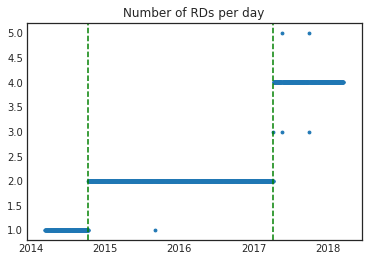

In [18]:
byDateDF = pd.DataFrame(submissionsDF[['date','created']]).groupby('date').count()
byDateDF.columns = ['num_RD']

plt.scatter(x=byDateDF.index, y=byDateDF['num_RD'], s = 8)

years = mdates.YearLocator()   
yearsFmt = mdates.DateFormatter('%Y')

ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set_title('Number of RDs per day')


#RD splits
plt.axvline(pd.to_datetime('2014-10-09'), linestyle = '--', color='g')
plt.axvline(pd.to_datetime('2017-04-07'), linestyle = '--', color='g')

plt.show()

There are still quite a few outliers given our expected regions. Let's check them out.

In [19]:
odd_dates = byDateDF[(byDateDF.index > datetime(2014,10,10).date()) &
                     (byDateDF['num_RD'] % 2 != 0)].index
print(odd_dates)
#submissionsDF[submissionsDF['date'].isin(odd_dates)]

Index([2015-09-04, 2017-04-07, 2017-05-18, 2017-05-19, 2017-09-28, 2017-09-29], dtype='object', name='date')


Upon checking the threads for 2017-04-07, we find out that it is a transition day where there were 3 RDs intentionally, before the moderators made 4 per day. So there's nothing to drop nor add. Just take note.

On the other hand, we see that the Nightly RD for 2017-09-28 (which the_yaya omitted posting) is user-posted and crossed over midnight to 2017-09-29. The same goes for the pair 2015-05-18 and 2017-05-19. We manually adjust these by moving the latter ones 10 minutes ahead. But we keep the 'created' field unchanged so we have access to the original and we can run the code over and over without nudging every time.  





In [20]:
nudge_ids = ['6bx3n0', '7312ju']

for nudge_id in nudge_ids:
    nudged_ts = submissionsDF.loc[nudge_id]['created'] - 600
    submissionsDF.at[nudge_id,'date'] = pd.to_datetime(nudged_ts, unit='s').date()

submissionsDF.loc[nudge_ids]

,author,created,n_comments,permalink,score,title,date
id,,,,,,,
6bx3n0,evilphotosynthesis,1.495152e+09,186,/r/Philippines/comments/6bx3n0/nightly_random_...,18,"Nightly random discussion - May 18, 2017",2017-05-18
7312ju,None,1.506643e+09,160,/r/Philippines/comments/7312ju/nightly_random_...,29,"Nightly Random Discussion - September 28, 2017",2017-09-28


Only 2015-09-0 remains unresolved. The last top level comment on the daily thread for 2015-09-04 was posted at 5:59 PM which indicates that there must be a nightly thread somewhere, but can't find it, even on Google. 

In [21]:
outlier = reddit.submission(id='3jjinu')
outlier.comments.replace_more(limit=None)
comment_datetime = [comment.created for comment in outlier.comments.list()]

print('Last comment posted on {}'.format(pd.to_datetime(max(comment_datetime),unit='s')))

Last comment posted on 2015-09-05 05:59:56


### Exploring the submissions dataset

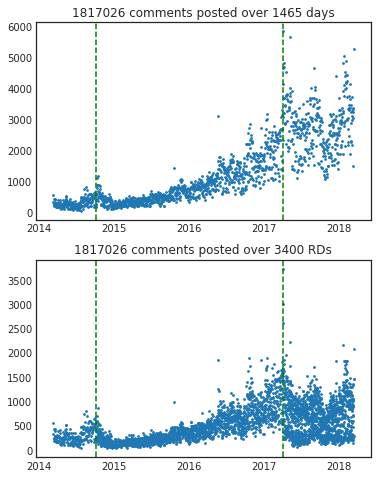

In [22]:
comment_per_day = submissionsDF[['date','n_comments']].groupby('date').sum()


fig, axarr = plt.subplots(2,1,figsize = (6,8))
plt.subplots_adjust(hspace=0.2)


axarr[0].scatter(x=comment_per_day.index, y=comment_per_day['n_comments'], s = 3)
axarr[0].set_title('{} comments posted over {} days'.format(comment_per_day['n_comments'].sum(),
                                                  (comment_per_day.index.max() - comment_per_day.index.min()).days))

axarr[1].scatter(x=pd.to_datetime(submissionsDF['created'], unit ='s').dt.date.values, y=submissionsDF['n_comments'], s = 3)
axarr[1].set_title('{} comments posted over {} RDs'.format(submissionsDF['n_comments'].sum(),
                                                      submissionsDF.shape[0]))

for ax in axarr:
    ax.xaxis.set_major_locator(years)
    ax.axvline(pd.to_datetime('2014-10-09'), linestyle = '--', color='g')
    ax.axvline(pd.to_datetime('2017-04-07'), linestyle = '--', color='g')

plt.show()


The split to four seems to have stemmed the rise of comment count per RD (for now... )

### Get all the comments!

Using submission ids from above, we download comments per RD. Like the submissions file, we update a local file of the comments data incrementally. This is imperative since the resulting comments data file is much larger than submissions. Beware, this can take quite long to run the first time!

In [31]:
if os.path.isfile(comments_file):
    commentsDF = pd.read_csv(comments_file, lineterminator='\n')
    remaining_ids = set(submissionsDF.index) - set(commentsDF['submission_id'].unique())
    print('Old comments file found containing {} comments and {} columns.'.format(commentsDF.shape[0], commentsDF.shape[1]))
    print('{} submissions remaining for comment extraction.'.format(len(remaining_ids)))
else:
    commentsDF = pd.DataFrame()
    remaining_ids = set(submissionsDF.index)
    print('No comments file found.')


Old comments file found containing 2033471 comments and 12 columns.
4 submissions remaining for comment extraction.


In [32]:
MAX_ATTEMPTS = 10
this_run_total = len(remaining_ids)
id_ctr = 0

for sub_id in remaining_ids:
    
    attempt_ctr = 0

    while attempt_ctr < MAX_ATTEMPTS:
        try:
            print('Attempting to fetch submission id {}...'.format(sub_id))
            
            submission = reddit.submission(id=sub_id)

            submission.comments.replace_more(limit=None)

            sub_comments = [{'id':str(comment.id),
                             'submission_id':submission.id,
                             'parent_id':comment.parent_id,
                             'author':comment.author,
                             'author_flair_text':comment.author_flair_text,
                             'permalink':submission.permalink,
                             'created': comment.created,
                             'score':comment.score,
                             #'ups':comment.ups,
                             #'downs':comment.downs,
                             'body':comment.body,
                             'depth':comment.depth,
                             'edited':comment.edited,
                             'gilded':comment.gilded
                             }

                            for comment in submission.comments.list()
                           ]

            sub_commentsDF = pd.DataFrame(sub_comments).set_index('id')                      
            remaining_ids = set(remaining_ids) - set(submission.id)
            id_ctr += 1

            if os.path.isfile(comments_file):
                with open(comments_file, 'a') as f:
                    sub_commentsDF.to_csv(f,header=False)
            else:
                 with open(comments_file, 'w') as f:
                    sub_commentsDF.to_csv(f)


            print('Processed submission id {} at {}, {} of {}'.format(submission.id, 
                                                                      datetime.now(),      
                                                                      id_ctr, 
                                                                      this_run_total
                                                                     )
                     )
            break

        except PRAWException:   
            print('Failed to fetch submission {} completely, retrying...'
                                     .format(submission.id))
             
        attempt_ctr +=1

        
print('Done.')


Attempting to fetch submission id 84sof4...
Processed submission id 84sof4 at 2018-03-17 09:07:07.515670, 1 of 4
Attempting to fetch submission id 84wgs5...
Processed submission id 84wgs5 at 2018-03-17 09:07:09.161205, 2 of 4
Attempting to fetch submission id 84u9vi...
Processed submission id 84u9vi at 2018-03-17 09:08:39.874425, 3 of 4
Attempting to fetch submission id 84qcrj...
Processed submission id 84qcrj at 2018-03-17 09:10:45.029730, 4 of 4
Done.


In [33]:
#Update comments dataframe
commentsDF = pd.read_csv(comments_file, lineterminator='\n')
print('Comments from {} submissions added to DF. Total number of comments now {}.'.format(ctr,commentsDF.shape[0]))
commentsDF.head()

Comments from 39 submissions added to DF. Total number of comments now 2038753.


,id,author,author_flair_text,body,created,depth,edited,gilded,parent_id,permalink,score,submission_id
0,csld81r,queen_senpai,Luzon_Master_Race,I'm secretly an atheist and I can't tell my re...,1.435526e+09,0,False,0,t3_3be1r2,/r/Philippines/comments/3be1r2/nightly_random_...,7,3be1r2
1,cslcyo5,universalbunny,大空で抱きしめて,TIL Charice made [a simlish version of Pyramid...,1.435525e+09,0,False,0,t3_3be1r2,/r/Philippines/comments/3be1r2/nightly_random_...,6,3be1r2
2,cslhsin,mingsaints,Pucha.,"Out of the blue, my ex sent me a message on fa...",1.435537e+09,0,False,0,t3_3be1r2,/r/Philippines/comments/3be1r2/nightly_random_...,5,3be1r2
3,cslbj32,alteregotistic,NaN,Local stand up? I'm a Jim Jeffries fan. Do we...,1.435518e+09,0,False,0,t3_3be1r2,/r/Philippines/comments/3be1r2/nightly_random_...,5,3be1r2
4,cslcoou,bloodycreature,(✿ ◕‿◕) ᓄ✂️╰U╯,Tawang tawa ako sa mga pabebe videos bakit ganon.,1.435523e+09,0,False,0,t3_3be1r2,/r/Philippines/comments/3be1r2/nightly_random_...,4,3be1r2


Even though comments have a 'created' attribute, we will use dates corresponding to the submission it belongs to, for consistency.

We first create a mini lookup table that matches submission id to date and create a new column in the comments dataframe that fills in the date from this lookup table.

In [34]:
submissionsLU = submissionsDF['date'].reset_index()
submissionsLU.columns = ['submission_id', 'date']
submissionsLU.head()

,submission_id,date
0,7vc3o4,2018-02-05
1,7dw2bp,2017-11-19
2,6p60d2,2017-07-24
3,2q7s9k,2014-12-24
4,3p9zcn,2015-10-19


In [35]:
commentsDF = submissionsLU.merge(commentsDF, how = 'right', on='submission_id')
commentsDF = commentsDF.set_index('id')
commentsDF.head()

,submission_id,date,author,author_flair_text,body,created,depth,edited,gilded,parent_id,permalink,score
id,,,,,,,,,,,,
dtrdkz0,7vc3o4,2018-02-05,Kingina_NorthV2,Popoy of the North,"i turned down the job waiting for me, and twic...",1.517843e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,27
dtr88bi,7vc3o4,2018-02-05,RedVelvetKun23,hideputo,We're playing an unspoken game where no one re...,1.517835e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,22
dtrfzln,7vc3o4,2018-02-05,coookiesncream,FRAGILE: Handle with Care,10 days na kong delayed at ang tanong ng nanay...,1.517848e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,19
dtr8xsd,7vc3o4,2018-02-05,marco_05,Tara! Laro tayo.,I just realized that r/PH should do Mo Twister...,1.517835e+09,0,1517807847.0,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,19
dtrcn8q,7vc3o4,2018-02-05,SarcasticSherlock,NaN,Just dropped by to say thanks for those who im...,1.517841e+09,0,1517823726.0,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,17


Again, a cursory glance:

In [36]:
commentsDF.isnull().any()

submission_id        False
date                 False
author                True
author_flair_text     True
body                  True
created              False
depth                False
edited               False
gilded               False
parent_id            False
permalink            False
score                False
dtype: bool

In [37]:
print('{} comments are associated with null authors.'.format(
    commentsDF[commentsDF['author'].isnull()]['date'].count())
     )
commentsDF[commentsDF['author'].isnull()].head()

326130 comments are associated with null authors.


,submission_id,date,author,author_flair_text,body,created,depth,edited,gilded,parent_id,permalink,score
id,,,,,,,,,,,,
dtrgvtj,7vc3o4,2018-02-05,NaN,NaN,"Hindi ko alam kung anong nangyari, pero kapag ...",1.517850e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,9
dtrahn5,7vc3o4,2018-02-05,NaN,NaN,Ang awkward palang mag-jog ng may suot na back...,1.517838e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,3
dtrcd77,7vc3o4,2018-02-05,NaN,NaN,[deleted],1.517840e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,2
dtrf3gi,7vc3o4,2018-02-05,NaN,NaN,[deleted],1.517846e+09,0,False,0,t3_7vc3o4,/r/Philippines/comments/7vc3o4/afternoon_rando...,1
dtrg3zn,7vc3o4,2018-02-05,NaN,NaN,Sabay sabay sila?? 😰,1.517848e+09,1,False,0,t1_dtrfzln,/r/Philippines/comments/7vc3o4/afternoon_rando...,1


We can replace null flairs and body text with '[empty_flair]' and '[empty_body]' respectively, but null authors are trickier. On one hand, we'd like to count them as authors as they existed at the time of posting a comment, but then we won't be able to distinguish one null author from another. We don't know when they deleted their accounts,too. So even if there are a sizeable number of now-null-authored comments,  we'll just keep them null so they don't appear when we group data by author. When we do count comments, we'll choose non-NaN columns. Counting authors/users would be less accurate. 

In [38]:
commentsDF['author_flair_text'] = commentsDF['author_flair_text'].fillna('[empty_flair]')
commentsDF['body'] = commentsDF['body'].fillna('[empty_body]')

In [39]:
commentsDF.describe()

,created,depth,gilded,score
count,2.038753e+06,2.038753e+06,2.038753e+06,2.038753e+06
mean,1.484307e+09,1.933888e+00,1.343959e-04,2.005578e+00
std,2.923915e+07,1.675842e+00,1.176018e-02,2.711544e+00
min,1.394606e+09,0.000000e+00,0.000000e+00,-5.200000e+01
25%,1.468527e+09,1.000000e+00,0.000000e+00,1.000000e+00
50%,1.491740e+09,1.000000e+00,0.000000e+00,1.000000e+00
75%,1.506279e+09,3.000000e+00,0.000000e+00,2.000000e+00
max,1.521277e+09,9.000000e+00,2.000000e+00,2.750000e+02


A few quick views:

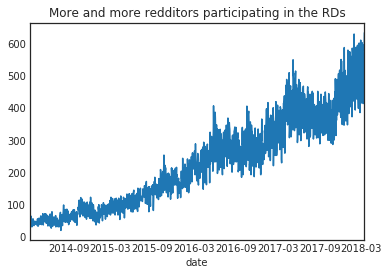

In [40]:
unique_authors = commentsDF[['date','author']].groupby('date').nunique()
unique_authors = unique_authors.drop('date', axis=1)
unique_authors.columns = ['unique_authors']

unique_authors.plot(title = 'More and more redditors participating in the RDs', legend = False)
plt.show()

Is there a steady stream of comments throughout the day? I bet not.

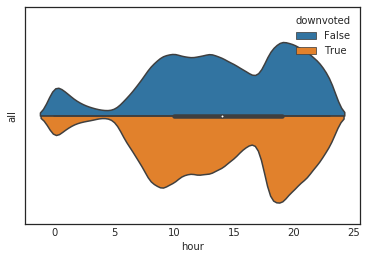

In [41]:
commentsDF['hour'] = pd.to_datetime(commentsDF['created'], unit='s').dt.hour
commentsDF['downvoted'] = (commentsDF['score'] < 0).astype('category')
commentsDF['all'] = ''

ax = sns.violinplot(data = commentsDF, y = 'all', x= 'hour'
                    , split = True, hue = 'downvoted',  bw = 0.1)


plt.show()

We can take a guess at an rPH RDer's day:

* 5AM - rise and RD!
* working hours - paid to RD
* around 3PM - oops I need to turn in _some_ work
* 6PM - off-work and RD
* around 11 pm - sleep?

(Assuming the overwhelming majority are posting from the Philippines, of course.)

Note that this violin plot is by posting hour, not voting hour. Also, the plot above is misleading because the downvoted distribution is inflated (not scaled to match count).  Let's look at the overall percentage of comments downvoted (taken here as negative score).

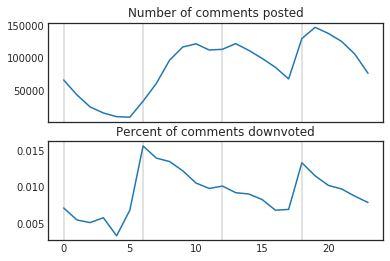

In [42]:
perc_downvoted = commentsDF[['downvoted', 'hour']].groupby('hour').sum() / commentsDF[['downvoted','hour']].groupby('hour').count()

fig, ax = plt.subplots(2,1, sharex = True)

ax[0].plot(commentsDF[['downvoted','hour']].groupby('hour').count())
ax[0].set_title('Number of comments posted')
ax[1].plot(perc_downvoted)
ax[1].set_title('Percent of comments downvoted')

for axis in ax:
    for i in [0,6,12,18]:
        axis.axvline(i, c = 'gray', alpha = 0.3)


Less than 2% of all comments are downvoted. The peaks correspond with the times the RD thread itself is posted(6AM and 6PM, but not 12NN and 12MN). Good to see the distribution and even better if we separate data into 1-RD, 2-RD and 4-RD period to clarify effects, if any.

Could be that at the start of the RD, a mix of upvote-y and downvote-y comments are posted as top level comments. The downvote-y comments posted early die naturally while the upvote-y ones get more replies which attract more upvotes (?) The RD is almost always sorted by New lately. Have to check if this applies to most RDs. Users could still be sorting by Best though, and there might be apps that change the deault sorting. 

In any case, let's try out different ways to visualize score distro.

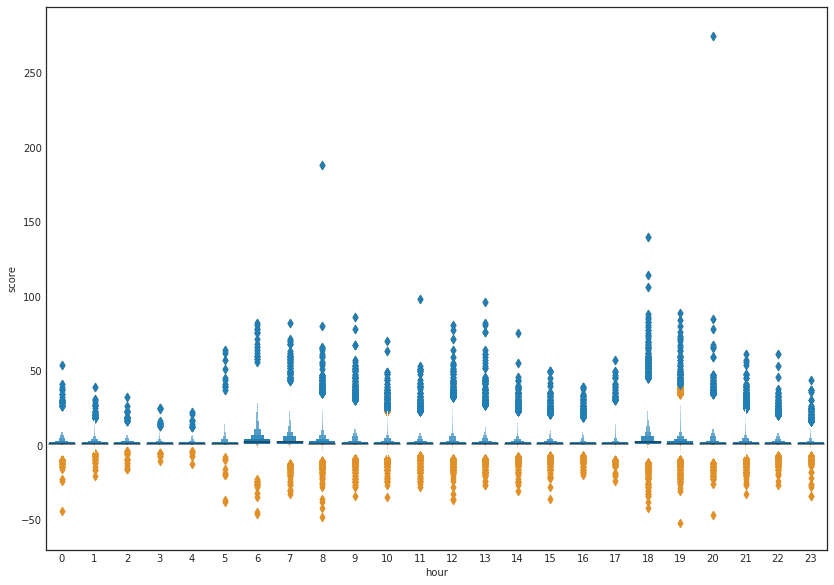

In [43]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.lvplot(ax = ax, data = commentsDF, y = 'score', x= 'hour',
           color = sns.xkcd_rgb["tangerine"],
          #dodge = False,
          #hue = 'downvoted',
         )

sns.lvplot(ax = ax, data = commentsDF[commentsDF['downvoted'] == False], y = 'score', x= 'hour',
           color = sns.xkcd_rgb["cerulean"],
          )
#ax.set_ylim(-10, 50)

plt.show()


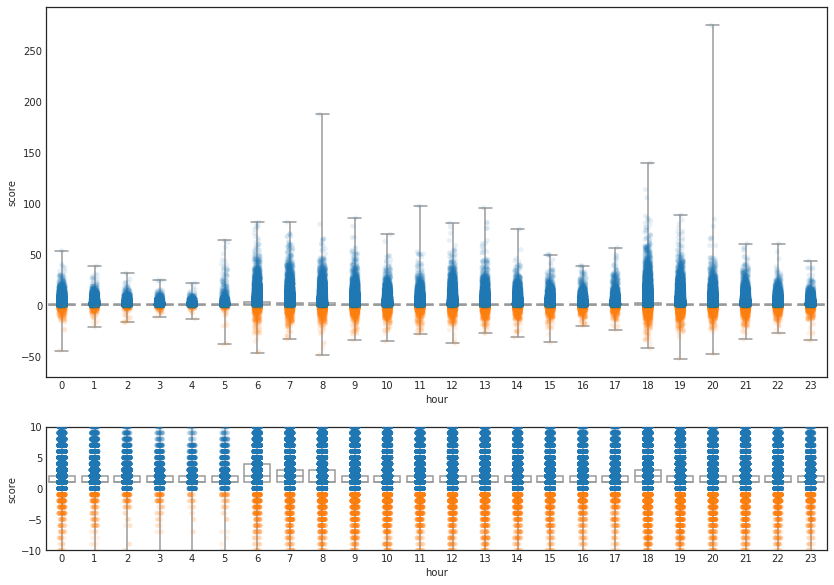

In [44]:
fig, ax = plt.subplots(2,1, figsize=(14, 10) , gridspec_kw = {'height_ratios':[3, 1]})
sns.stripplot(ax = ax[0], data = commentsDF, y = 'score', x= 'hour',
                   dodge = False, hue = 'downvoted',
                   alpha=0.1, jitter = True,
                  )
ax[0].legend_.remove()    
#ax[0].set_ylim(-50, 75)


sns.boxplot(ax = ax[0], data = commentsDF, y = 'score', x= 'hour',
            whis=np.inf,
            color = 'white',
           )

sns.stripplot(ax = ax[1], data = commentsDF, y = 'score', x= 'hour',
              dodge = False, hue = 'downvoted',
              alpha=0.1, jitter = True,
             )

ax[1].legend_.remove()
ax[1].set_ylim(-10, 10)

sns.boxplot(ax = ax[1], data = commentsDF, y = 'score', x= 'hour',
            whis=np.inf,
            color = 'white'
           )

plt.show()

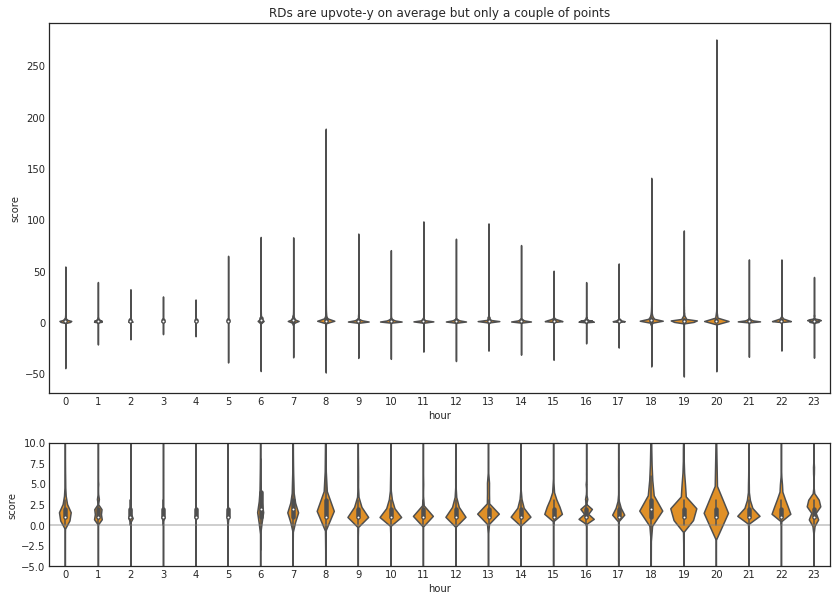

In [45]:
fig, ax = plt.subplots(2,1, figsize=(14, 10) , gridspec_kw = {'height_ratios':[3, 1]})
sns.violinplot(ax = ax[0], data = commentsDF, y = 'score', x= 'hour',
               scale = 'count',
              #dodge = False,
              #split = True,
              #hue = 'downvoted',
              #bw = 0.1,
               color = sns.xkcd_rgb["tangerine"],
              )
sns.violinplot(ax = ax[1], data = commentsDF, y = 'score', x= 'hour',
               scale = 'count',
              #dodge = False,
              #split = True,
              #hue = 'downvoted',
              #bw = 0.1,               
               color = sns.xkcd_rgb["tangerine"],
              )

ax[0].set_title('RDs are upvote-y on average but only a couple of points')
ax[1].set_ylim(-5, 10)
ax[1].axhline(0, c = 'gray', alpha = 0.5)

plt.show()

For karma (reddit reputation points) farming, larger audience size is desirable (assuming a more or less constant upvote-tendency). What we actually need to quantify 'audience' is the number of redditors reading the RD at a given time, but we don't have that. We can, however, look at the the number of redditors posting. 



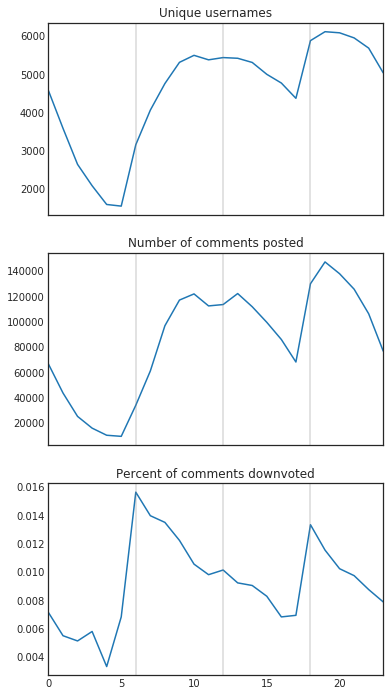

In [46]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(6, 12) )
plt.subplots_adjust(hspace=0.2)

axarr[0].plot(commentsDF[['author','hour']].groupby('hour').nunique()['author'])
axarr[0].set_title('Unique usernames')

axarr[1].plot(commentsDF[['downvoted','hour']].groupby('hour').count())
axarr[1].set_title('Number of comments posted')

axarr[2].plot(perc_downvoted)
axarr[2].set_title('Percent of comments downvoted')

for ax in axarr:
    for i in [0,6,12,18]:
        ax.axvline(i, c = 'gray', alpha = 0.3)
        ax.set_xlim(0,23)


Oops, should we have taken the average per hour over days instead of total?

In [47]:
hourDF = pd.DataFrame()
hourDF['unique_authors'] = commentsDF[['author','date','hour']].groupby(['date','hour']).nunique()['author']
hourDF['n_comments'] = commentsDF[['author','date','hour']].groupby(['date','hour']).count()
commentsDF['downvoted'] = commentsDF['downvoted'].astype(bool)
hourDF['downvoted'] = commentsDF[['downvoted','date','hour']].groupby(['date','hour']).sum() 
hourDF['perc_downvoted'] = (hourDF['downvoted'] / hourDF['n_comments']).replace(np.inf, 0)
hourDF = hourDF.reset_index()
hourDF.head()

,date,hour,unique_authors,n_comments,downvoted,perc_downvoted
0,2014-03-12,1,1,2,0.0,0.0
1,2014-03-12,2,1,1,0.0,0.0
2,2014-03-12,3,1,2,0.0,0.0
3,2014-03-12,4,1,1,0.0,0.0
4,2014-03-12,5,2,4,0.0,0.0


In [48]:
hourDFp = hourDF.pivot(index = 'hour', columns= 'date').fillna(0)

base_colors = [sns.xkcd_rgb["cerulean"], sns.xkcd_rgb["tangerine"], sns.xkcd_rgb["pale red"]]
dark_colors = [sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["burnt orange"], sns.xkcd_rgb["burnt red"]]
columns = ['unique_authors', 'n_comments', 'perc_downvoted']
titles = ['Unique authors', 'Comments posted', 'Percent downvoted']

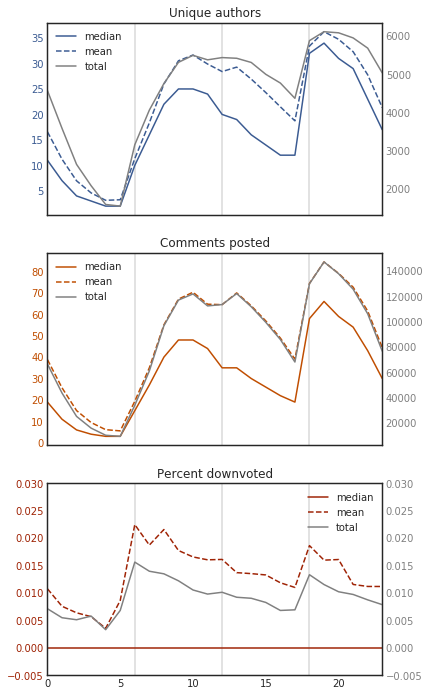

In [49]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(6, 12) )
plt.subplots_adjust(hspace=0.2)

fig.set

for ax in axarr:
    for i in [0,6,12,18]:
        ax.axvline(i, c = 'gray', alpha = 0.3)

axt0 = axarr[0].twinx()
axt1 = axarr[1].twinx()
axt2 = axarr[2].twinx()

#ax1.get_shared_y_axes().join(ax1, ax3)

axt0.plot(commentsDF[['author','hour']].groupby('hour').nunique()['author'], c = 'gray', label = 'total')
axt1.plot(commentsDF[['downvoted','hour']].groupby('hour').count(), c = 'gray', label = 'total')
axt2.plot(perc_downvoted, c = 'gray', label = 'total')


for ax, col, title, color, axt in zip(axarr,columns,titles,dark_colors, [axt0,axt1,axt2]):
    ax.plot(hourDFp[col].median(axis=1), c = color, label = 'median')
    ax.plot(hourDFp[col].mean(axis=1), c = color, ls = '--', label = 'mean')
    ax.set_title(title)
    ax.set_xlim(0,23)  
    
    ax.tick_params('y', colors=color)
    axt.tick_params('y', colors='gray')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axt.get_legend_handles_labels()
    axt.legend(lines + lines2, labels + labels2, loc=0)
    

axarr[2].set_ylim(-0.005, 0.03)
axt2.set_ylim(-0.005, 0.03)
       
plt.show()

The overall trend for number of comments and unique users is the same, though the decrease in the afternoon is steeper when the median of the daily average is taken. The peak around noon is also lost. Perhaps the spike is due to the afternoon RD opening (there was no separate afternoon RD in the 'early days').

The percentage of comments downvoted is drastically different for mean and median. See distribution below.

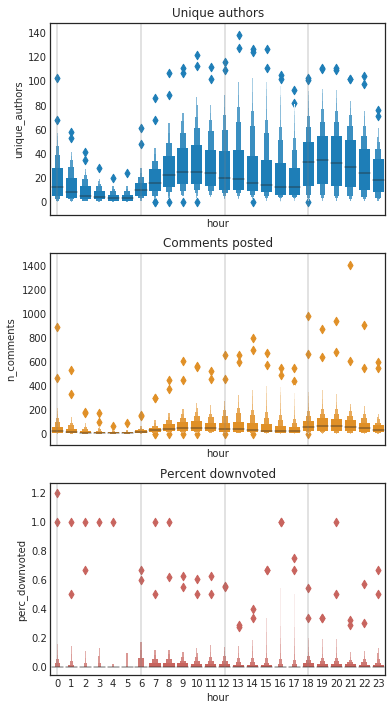

In [50]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(6, 12) )
plt.subplots_adjust(hspace=0.2)

for ax, col, title, color in zip(axarr,columns,titles,base_colors):
    sns.lvplot(ax = ax, data=hourDF, x = 'hour', y = col, color = color)
    ax.set_title(title)

for ax in axarr:
    for i in [0,6,12,18]:
         ax.axvline(i, c = 'gray', alpha = 0.3)


In the graph below, each line traces a specific date while the thicker line is the median. Seems like there are different modes of behavior (see two blue streams?) Must separate the 1-, 2- and 4-RD periods. 

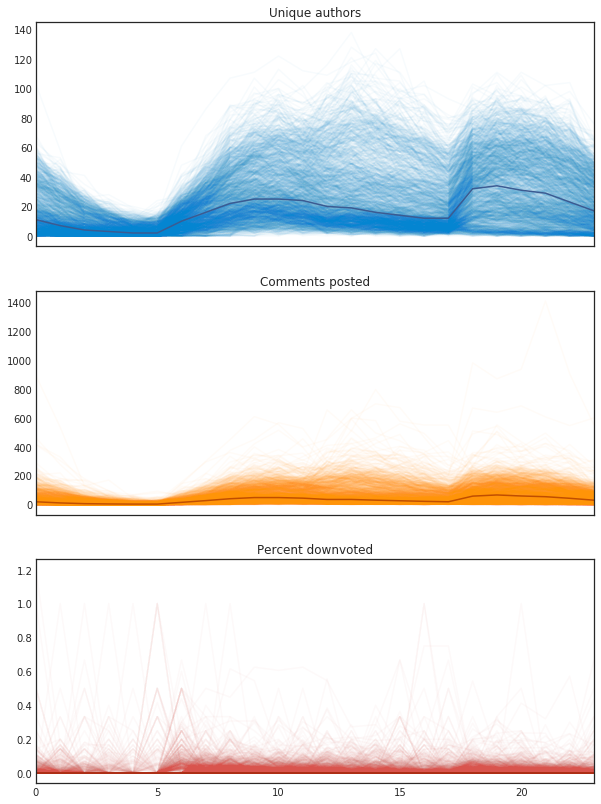

In [51]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(10, 14) )
plt.subplots_adjust(hspace=0.2)


for ax, col, title, color1, color2 in zip(axarr,columns,titles,base_colors,dark_colors):

    ax.plot(hourDFp[col], alpha = 0.03, c = color1)
    ax.plot(hourDFp[col].median(axis=1), c = color2)
    ax.set_title(title)
    ax.set_xlim(0,23)

plt.show()


Separating the  1-, 2- and 4-RD periods reveal that posting behavior has changed along with the number of RDs per day. 

In [52]:
oneRDend = pd.to_datetime('2014-10-09')
twoRDend = pd.to_datetime('2017-04-07')
fourRDend = hourDFp['n_comments'].columns.max()

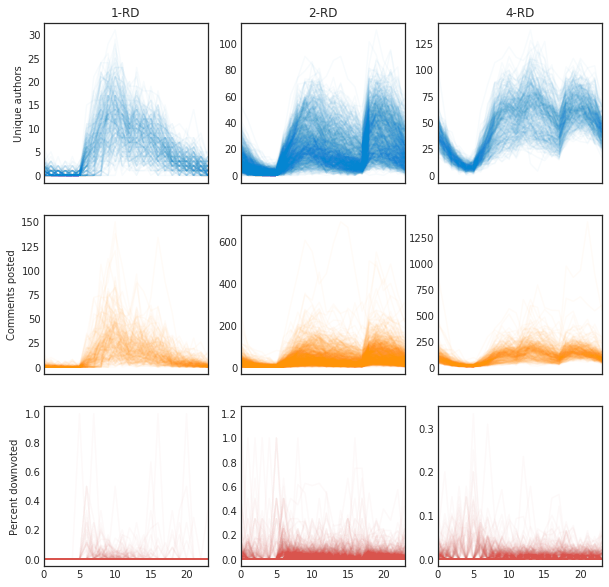

In [53]:
fig, axarr = plt.subplots(3,3, sharex = True, figsize=(10, 10),
                      #sharey = 'row', 
                      )
plt.subplots_adjust(hspace=0.2)

for i,col,title,color in zip(range(3),columns, titles, base_colors):
    axarr[i,0].plot((hourDFp[col].T)[inception:oneRDend].T, alpha = 0.03, c = color)
    axarr[i,1].plot((hourDFp[col].T)[oneRDend+timedelta(days=1):twoRDend].T, alpha = 0.03, c = color)
    axarr[i,2].plot((hourDFp[col].T)[twoRDend+timedelta(days=1):fourRDend].T, alpha = 0.03, c = color)
    axarr[i,0].set_ylabel(title)
    plt.xlim(0,23)
    
axarr[0,0].set_title('1-RD')
axarr[0,1].set_title('2-RD')
axarr[0,2].set_title('4-RD')

plt.show()

Counterpoint: Or was the behavior already changing and the RD split was an adaptation?

In [54]:
#plot with slider for date

So what time and day is it a good time to post for greater visibility, now that we know behavior is different for the 4-RD period? 

In [55]:
hourDF['dayofweek'] = pd.to_datetime(hourDF['date']).dt.dayofweek

Let's focus on the 4-RD period.

In [56]:
dowAVE = hourDF[hourDF['date'] > twoRDend.date()].drop('date',axis=1).groupby(['dayofweek','hour']).mean()
dowAVE = dowAVE.unstack()
dowAVE.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

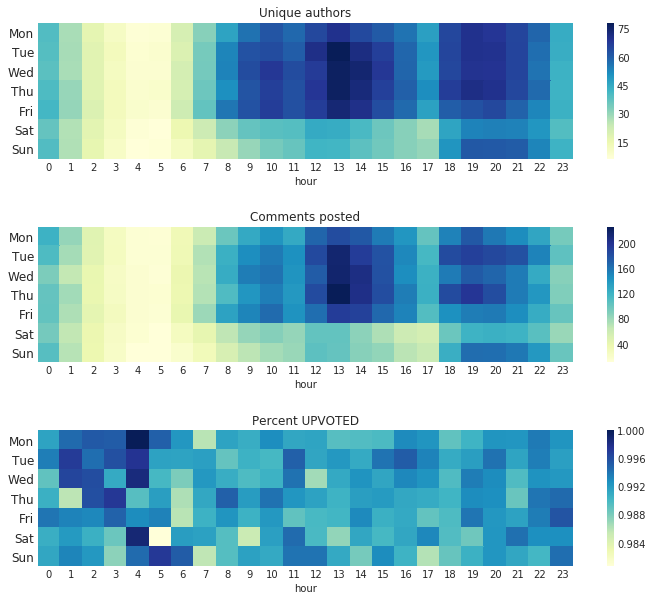

In [57]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(12, 10)
                      # , sharey = 'row' 
                      )
plt.subplots_adjust(hspace=0.5)

sns.heatmap(dowAVE['unique_authors'], ax = axarr[0],cmap="YlGnBu")
axarr[0].set_title('Unique authors')

sns.heatmap(dowAVE['n_comments'], ax = axarr[1], cmap="YlGnBu")
axarr[1].set_title('Comments posted')

# For visual consistency of 'desireable areas', plot percent upvoted
sns.heatmap(1 - dowAVE['perc_downvoted'], ax = axarr[2], cmap="YlGnBu")
axarr[2].set_title('Percent UPVOTED')

for ax in axarr:
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)

The percent of downvoted comments (or upvoted comments in this case) may just be a matter of downvoted comments being diluted by more comments during that hour. Anyway, the difference is quite small.

For a wider audience, post 1PM on a weekday. Seems like RD-ers have some semblance of real-world Friday nightlife and are otherwise occupied on weekends.

In contrast, see the heatmaps for all periods.

In [58]:
dowAVE = hourDF.drop('date',axis=1).groupby(['dayofweek','hour']).mean()
dowAVE = dowAVE.unstack()
dowAVE.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

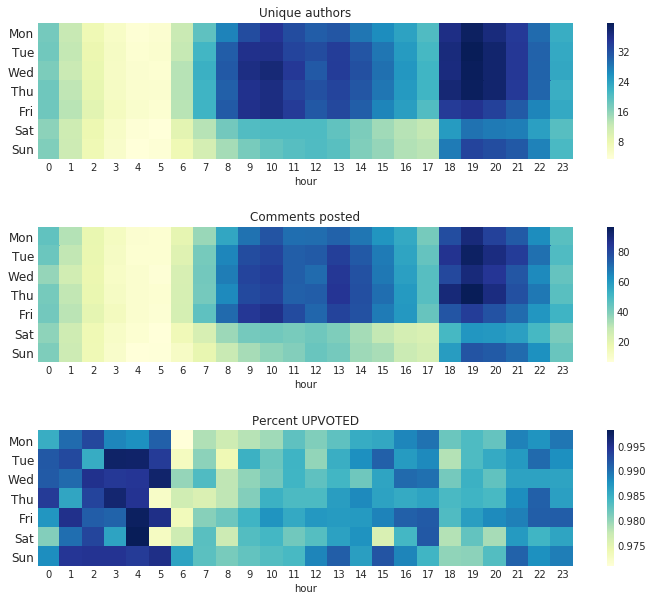

In [59]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(12, 10)
                      # , sharey = 'row' 
                      )
plt.subplots_adjust(hspace=0.5)

sns.heatmap(dowAVE['unique_authors'], ax = axarr[0],cmap="YlGnBu")
axarr[0].set_title('Unique authors')

sns.heatmap(dowAVE['n_comments'], ax = axarr[1], cmap="YlGnBu")
axarr[1].set_title('Comments posted')

# For visual consistency of 'desireable areas', plot percent upvoted
sns.heatmap(1 - dowAVE['perc_downvoted'], ax = axarr[2], cmap="YlGnBu")
axarr[2].set_title('Percent UPVOTED')

for ax in axarr:
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)

### Ang Pinaka

In [60]:
print('TOP SCORING POSTS\n')
top10score = (commentsDF.sort_values('score', ascending = False))[['author','body', 'score']].head(10)

for i in range(3):
    print('************\nAt # {} with {} points by u/{}:\n {}\n'.format(i+1, top10score['score'][i],
                                                         top10score['author'][i], top10score['body'][i]))

TOP SCORING POSTS

************
At # 1 with 275 points by u/PM_M3_YOUR_PA55WORD:
 Kanina sa office, kinwento ko sa officemates ko na nanood ako ng Coco nang mag-isa and my office mate said that he's going to watch it alone tomorrow. Another office mate then replied, *"Bakla ka ba? Maghahanap ka ng booking sa sinehan? Mga bakla lang daw usually nanonood ng sine mag-isa. Hahaha."* in a snark tone. I wanted to snap back at his remark, but I couldn't. People like him are the reason I still don't want to come out. 

This guy also happens to be a low-key DDS. I also heard him say, *"Sana taasan yung pamasahe sa MRT para hindi na makasakay yung mga mahihirap."* Kung di lang sana 'to malaking tao, matagal ko nang inaway. Tangina mo Aldrin.

************
At # 2 with 188 points by u/_IchigoIchie:
 5 years ago, we had a new hire who latter joined my Team in which I have to supervise. The nature of our work involves minor programming and conducting client visit to train and present our product. We

Let's create a new dataframe for user-based stats.

In [61]:
print('There are {} comments with null authors (deleted accounts)'.format(commentsDF['author'].isnull().sum()))

There are 326130 comments with null authors (deleted accounts)


Groupby automatically ignores null values.

In [62]:
redditorsDF = commentsDF[['author','score', 'gilded', 'depth']].groupby('author').sum()
redditorsDF['n_comments'] = commentsDF[['author','score']].groupby('author').count()
redditorsDF = redditorsDF.rename(columns={'score': 'total_score', 
                                           'gilded':'total_gilded', 
                                           'depth':'total_depth'})
redditorsDF.head()

,total_score,total_gilded,total_depth,n_comments
author,,,,
--FinAlize,72,0,41,33
--KuyaJ_,3,0,1,1
-01123581321345589-,83,0,60,31
-3005,4,0,0,3
-Aldrin-,11,0,10,5


We can easily show who has received the most reddit gold. 

In [63]:
print('MOST GILDED')
redditorsDF.sort_values('total_gilded', ascending = False)[['total_gilded', 'n_comments']].head(10)

MOST GILDED


,total_gilded,n_comments
author,,
psst-got-real,6,3871
murse_with_moobs,5,5955
Un1t-X,4,1340
Potatina,4,595
jiliciousrn,3,200
mitselschisels,3,3179
BearsbyBears,3,3730
NotAikoYumi,3,18593
prestige_beauty,3,812


We'll also create another DF broken down by day to get a profile of which users are active per day. Not looking at per RD here, since there are days with 1 or 2 or 4 RDs. This way, users can participate in one or a few RDs and count as active. (Though some may be active in all RDs! They call themselves no-lifers :p Participants live in different timezones, too.)

In [64]:
dailyDF = commentsDF[['date','author','score']].groupby(['date','author']).count()
dailyDF = dailyDF.rename(columns = {'count':'n_comments'})
dailyDF = dailyDF.unstack(fill_value = 0)
dailyDF.columns = dailyDF.columns.get_level_values(1)
dailyDF.head()

author,--FinAlize,--KuyaJ_,-01123581321345589-,-3005,-Aldrin-,-And-Peggy-,-Blitzen,-Bughaw-,-ELJuicyBacon,-EdoTensei,-Estupida-,-Friday_Rat-,-GCF,-Guernica,-HuggyBear-,-Kuya,-La_Geass-,-Paranoia,-RailGun-,-RememberMe-,-SexyBeast,-Throw_Away_Account-,-Zeeero,-bbustanutt-,-crypticpattern,-essi-,-ffffff,-flyhigh-,-habagat-chick-,-hello_world_,-hellogoodbye,-inator,-kindakrazy-,-leloo-,-lightfury-,-mayumi-,-memento-mori,-mr-throwaway-,-ph0enix-,-tRabbit,-thatswhatshesaid,-trowawaybarton,-tukso-,-violette-,-zonrox-,00000_,0010001_1,00327AA343,00o0o00,01001010_01001101,0101001001110010043N,01011000X,011418,01189998819991197tu5,013V34,01cabeliza,01geli,022890,0304slurpee,033054,052189ao,0819-,092284,09262225422,0927123,0934230,0Leviathan0,0detosleep,0egg,0foxdec,0kills,0ldg0ld,0scar-kil0,0xsherwin,0yen,1-800-Pi,1000pain,10071595,100789,100one,101010anon,1011pm,1063526266327193,10747788,10YearsANoob,10araw,11002233,1111241111,1111eleveneleven,1111hyong,11212212,1127bolivar,11548361,11_19khad,11thplace,1216996,123089dc,12313132344324345353,123AsawaNiMarie,123choji,...,yumicecream,yummygummytummy,yummypunani,yuneedan,yunipay,yuppiyuo,yurilith,yurinforit,yuuranni,yuzucchi,yyedditt,yzarcyeknom,z3rb,zEno_17,zEvilGuy,zSuicideSheep,z_mazinger,zaaanovavitch,zaba_prince,zamanyly,zandrach,zanezki,zao_meshikov,zapxcero,zariazelle,zatannaa,zboltz,zdc21,zddie,zealotofcynicism,zeapple,zedfrostxnn,zeeeguy,zeekers05,zeethezee,zehkee,zeitgeist_139,zekecahill,zekester10,zen970804,zenCompiler,zenerd1ode,zenithisland,zenkkai2,zenofthefuries,zenzenhyun,zephyrain,zer0wl,zeroeightviii,zeromaya,zerouji,zerrypie,zeseries,zeuxisz,zhern012,zhern01234,zhytwos,ziad45,ziaddaiz,zielbertryle,zigzagzig,zilt0ide,zilvertear,zioure,zipitfast,zipperzapper,zizzle-stick,zjhun,zjica,zjomea,zjzr_08,zkere,zoldyckbaby,zomNick,zombiebabe4eva,zoned_tider,zonickxxx,zonrox,zoominfeature,zsazsaZaturnnah,ztac_dex,ztgl,zukushikimimemo,zunjae,zurc_melanion,zuvawa,zweiarmer,zweisswrites,zwenzens,zwreid,zxccxzz,zxwx,zygrush,zyphoxan,zyphyrkhyts,zypros026,zywin_lannister,zz_zzz,zzz_coder,zzzss
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-03-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [65]:
redditorsDF['days_present'] = (dailyDF > 0).sum()
redditorsDF.head()

,total_score,total_gilded,total_depth,n_comments,days_present
author,,,,,
--FinAlize,72,0,41,33,8
--KuyaJ_,3,0,1,1,1
-01123581321345589-,83,0,60,31,9
-3005,4,0,0,3,2
-Aldrin-,11,0,10,5,2


How do we define top users? One way would be to look at who has posted the most number of comments so far. Another would be to look at who has been active the most days since the RDs started. Note that newer users are 'disadvantaged' under this definition because they don't have time on their side.

In [66]:
most_comments_all_time = redditorsDF.sort_values('n_comments', ascending = False).head(10).index.values
most_comments_all_time

array(['Fulltergeist', 'NotAikoYumi', 'Mr_Connie_Lingus69', 'Pasencia',
       'FecklessFool', 'Aeronautique_F', 'toshi04', 'sakundes',
       'cardboardbuddy', 'thenameisgsarci'], dtype=object)

In [67]:
most_active_all_time = redditorsDF.sort_values('days_present', ascending = False).head(10).index.values
most_active_all_time

array(['toshi04', 'the_yaya', 'blackcoffin90', 'hellotheremiss',
       'pintasero', 'evilphotosynthesis', 'gingangguli', 'decayedramen',
       'scubadance', 'MeepXD'], dtype=object)

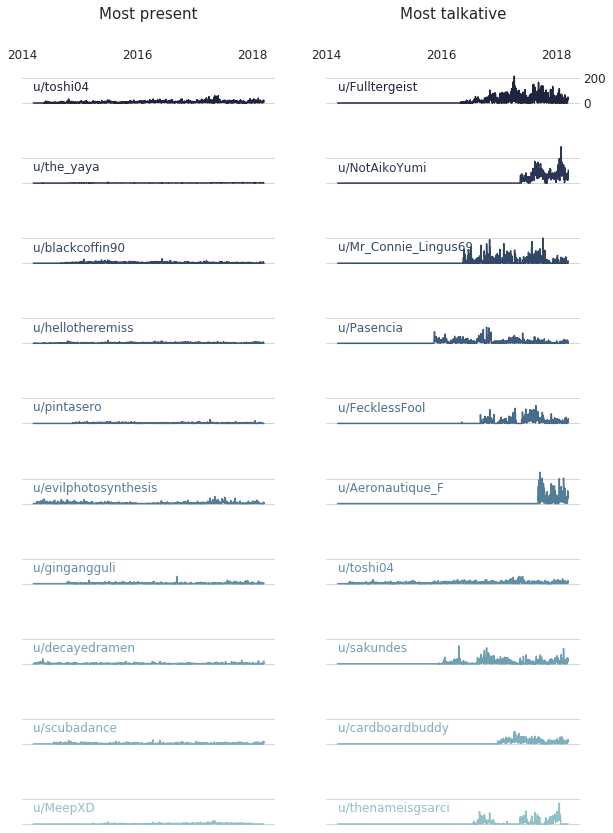

In [68]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)[::-1]
    
years = mdates.YearLocator(2)   # every other year
yearsFmt = mdates.DateFormatter('%Y')

f, axarr = plt.subplots(10, 2, sharex=True, sharey=True, figsize=(10, 14))
plt.subplots_adjust(hspace=1, wspace = 0.2)

top_users = [most_active_all_time, most_comments_all_time]

for i in range(2):
    
    for ax, user, color in zip(axarr.T[i], top_users[i], pal):
        
        ax.plot(dailyDF.index, dailyDF[user], c = color)
        ax.set_frame_on(False)
        #ax.grid(False)
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)    
        ax.tick_params(axis='both',labelleft='off', labeltop='off', labelright='off', labelbottom='off')
        ax.text(dailyDF.index[0], 100, 'u/{}'.format(user), 
                     {'fontsize': 12,
                      'horizontalalignment': 'left',
                      'color': color},
                )
    
    
    
axarr[0,0].set_title('Most present', y = 2, fontsize = 15 )    
axarr[0,0].tick_params(axis='x', labelleft='off', labeltop='on', labelright='off', labelbottom='off', labelsize = 12)

axarr[0,1].set_title('Most talkative', y = 2, fontsize = 15 )
axarr[0,1].tick_params(axis='y', labelleft='off', labeltop='off', labelright='on', labelbottom='off', labelsize = 12)
axarr[0,1].tick_params(axis='x', labelleft='off', labeltop='on', labelright='off', labelbottom='off', labelsize = 12)




From the right-hand-side panel, we observe that some redditors were 'late to the party' so to speak, but once they got in, they talked up a storm! Others, like u/toshi04 have a slow-but-steady type of approach.

We'll use the term 'age' to denote the number of days since a particular redditor started posting. 

One metric we can consider is presence rate. We can take the number of days a redditor participated in any RD of the day over (a) all the possible days s/he could have participated since she first posted in the RD ('age'), or (b) all the days in which s/he was active (s/he could have stopped participating after some date). But (b) is problematic if we consider redditors who only posted once the entire time. That redditor's presence rate will be a perfect 1! (a) is also problematic because now, 'younger' redditors have unfair advantage (e.g. I started posting yesterday so I have 100% presence rate)


In [69]:
tempDF = dailyDF.T > 0
cols = tempDF.columns
tempDF = tempDF.apply(lambda x: list(cols[x.values]), axis=1)
redditorsDF['first_post_date'] = tempDF.apply(lambda x: min(x))
redditorsDF['last_post_date'] = tempDF.apply(lambda x: max(x))
redditorsDF['days_active'] = (redditorsDF['last_post_date'] - redditorsDF['first_post_date']).dt.days + 1
redditorsDF['age_in_days'] = (dailyDF.index.max() - redditorsDF['first_post_date']).dt.days + 1
redditorsDF['presence_rate_since_birth'] = redditorsDF['days_present'] / redditorsDF['age_in_days'] 
redditorsDF['presence_rate_while_active'] = redditorsDF['days_present'] / redditorsDF['days_active']
print('Total number of RD participants: {}'.format(redditorsDF.shape[0]))
redditorsDF.head()

Total number of RD participants: 15628


,total_score,total_gilded,total_depth,n_comments,days_present,first_post_date,last_post_date,days_active,age_in_days,presence_rate_since_birth,presence_rate_while_active
author,,,,,,,,,,,
--FinAlize,72,0,41,33,8,2017-09-08,2018-02-01,147,190,0.042105,0.054422
--KuyaJ_,3,0,1,1,1,2018-02-11,2018-02-11,1,34,0.029412,1.000000
-01123581321345589-,83,0,60,31,9,2016-10-26,2017-03-19,145,507,0.017751,0.062069
-3005,4,0,0,3,2,2016-06-20,2016-07-16,27,635,0.003150,0.074074
-Aldrin-,11,0,10,5,2,2017-12-04,2017-12-05,2,103,0.019417,1.000000


A lot are hit-and-run.

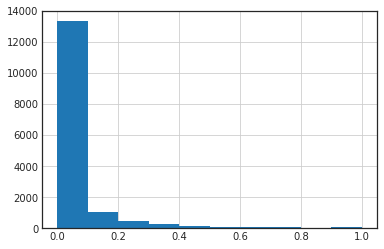

In [70]:
redditorsDF['presence_rate_since_birth'].hist()

A histogram of presence_rate_while_active indicates many of these hit-and-runners may be once-and-never-again-ers (OANAs), instead of being infrequent posters. Could be casuals or throwaways (accounts used for posting once or a few times and discarded).

5782 participants appear once and never again.


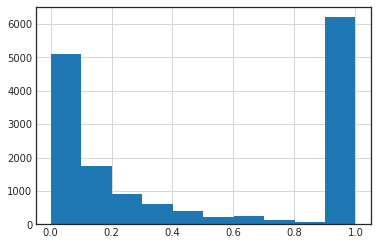

In [71]:
redditorsDF['presence_rate_while_active'].hist()

print('{} participants appear once and never again.'.format((redditorsDF['days_active'] == 1).sum()))

OANA count seems to be increasing lately.

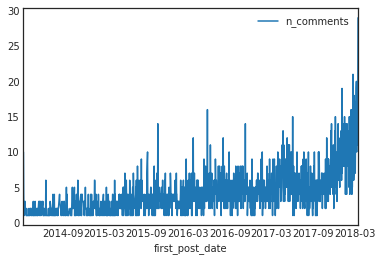

In [72]:
OANAs = redditorsDF[redditorsDF['days_present'] == 1].index
nonOANAs = redditorsDF[redditorsDF['days_present'] > 1].index
redditorsDF.loc[OANAs][['first_post_date', 'n_comments']].groupby('first_post_date').count().plot()
plt.show()

Can OANAs account for increase in unique users?

In [73]:
###


If we plot date of last post versus date of first post, the diagonal will be populated by users who only posted once. The top part will be populated by users who are still active (or recently active). Each point is a user and the size of the point is proportional to the total number of comments made by the user. 


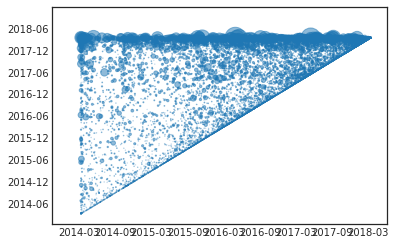

In [74]:
first_dates = pd.to_datetime(redditorsDF['first_post_date']).values
last_dates = pd.to_datetime(redditorsDF['last_post_date']).values

plt.scatter(x = first_dates, y = last_dates, s = redditorsDF['n_comments']/50, alpha= 0.5)

plt.show()

Let's try number of comments per day since first post. The top redditors here would be those who started and chatted the most since then. Interestingly, they have perfect attendance (from since they enrolled)! 

In [75]:
redditorsDF['n_comments_per_day_since_birth'] = redditorsDF['n_comments'] / redditorsDF['age_in_days'] 
redditorsDF['n_comments_per_day_while_active'] = redditorsDF['n_comments'] / redditorsDF['days_active']
redditorsDF.sort_values('n_comments_per_day_since_birth', ascending = False).head()

,total_score,total_gilded,total_depth,n_comments,days_present,first_post_date,last_post_date,days_active,age_in_days,presence_rate_since_birth,presence_rate_while_active,n_comments_per_day_since_birth,n_comments_per_day_while_active
author,,,,,,,,,,,,,
Rav_Fontanilla,14201,1,23344,7837,70,2018-01-04,2018-03-16,72,72,0.972222,0.972222,108.847222,108.847222
NotAikoYumi,40147,3,42652,18593,297,2017-05-15,2018-03-16,306,306,0.970588,0.970588,60.761438,60.761438
Aeronautique_F,22904,2,27788,10794,173,2017-09-06,2018-03-16,192,192,0.901042,0.901042,56.218750,56.218750
ChinChunSu,10901,2,9029,4067,90,2017-12-16,2018-03-16,91,91,0.989011,0.989011,44.692308,44.692308
popopoldoman,13865,1,24622,8369,181,2017-09-01,2018-03-16,197,197,0.918782,0.918782,42.482234,42.482234


In [76]:
redditorsDF['n_comments_per_day_since_birth'].describe()

count    15628.000000
mean         0.334239
std          1.881524
min          0.000682
25%          0.004630
50%          0.020513
75%          0.121088
max        108.847222
Name: n_comments_per_day_since_birth, dtype: float64

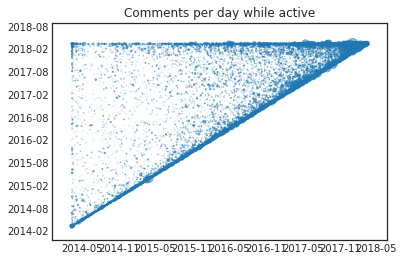

In [77]:
plt.scatter(x = first_dates, y = last_dates, s = redditorsDF['n_comments_per_day_while_active'], alpha= 0.5)
plt.title('Comments per day while active')
plt.show()

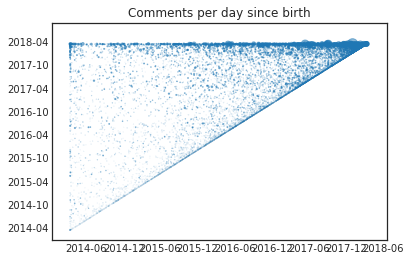

In [78]:
plt.scatter(x = first_dates, y = last_dates, s = redditorsDF['n_comments_per_day_since_birth'], alpha= 0.5)
plt.title('Comments per day since birth')
plt.show()

The 'ideal' RD redditor would be one who has been posting since inception and posting a lot per day since then (top left corner). The other end of the spectrum would be someone who is new and rarely posts. Let's define a metric 'rating' which (for now) naively takes the product of these two factors. The higher this metric is, the 'better' the redditor.

In [79]:
tempDF = redditorsDF[['n_comments_per_day_since_birth','age_in_days']]
scaler = preprocessing.MinMaxScaler()
scaledDF = scaler.fit_transform(tempDF)
scaledDF = pd.DataFrame(scaledDF, columns=['n_comments_per_day_since_birth','age_in_days'], index = tempDF.index)
redditorsDF['rating'] = scaledDF['n_comments_per_day_since_birth'] * scaledDF['age_in_days']

redditorsDF.sort_values('rating', ascending = False).head(10)

,total_score,total_gilded,total_depth,n_comments,days_present,first_post_date,last_post_date,days_active,age_in_days,presence_rate_since_birth,presence_rate_while_active,n_comments_per_day_since_birth,n_comments_per_day_while_active,rating
author,,,,,,,,,,,,,,
Fulltergeist,44264,2,42723,21324,581,2016-04-29,2018-03-16,687,687,0.845706,0.845706,31.039301,31.039301,0.133529
NotAikoYumi,40147,3,42652,18593,297,2017-05-15,2018-03-16,306,306,0.970588,0.970588,60.761438,60.761438,0.116217
Mr_Connie_Lingus69,18992,0,32924,13492,429,2016-05-18,2018-03-16,668,668,0.642216,0.642216,20.197605,20.197605,0.084481
Pasencia,19456,0,23198,11819,691,2015-11-14,2018-03-16,854,854,0.809133,0.809133,13.839578,13.839578,0.074028
FecklessFool,23269,1,21988,11198,466,2016-05-07,2018-03-16,679,679,0.686303,0.686303,16.491900,16.491900,0.070118
Aeronautique_F,22904,2,27788,10794,173,2017-09-06,2018-03-16,192,192,0.901042,0.901042,56.218750,56.218750,0.067338
toshi04,20739,0,16503,10350,1279,2014-05-14,2018-03-16,1403,1403,0.911618,0.911618,7.377049,7.377049,0.064854
sakundes,16498,1,20094,9863,502,2015-10-22,2018-03-16,877,877,0.572406,0.572406,11.246294,11.246294,0.061778
cardboardbuddy,26075,2,20054,9657,443,2016-09-03,2018-03-16,560,560,0.791071,0.791071,17.244643,17.244643,0.060450


The number of comments is so skewed that it completely dominated the trend. 

The same members? True


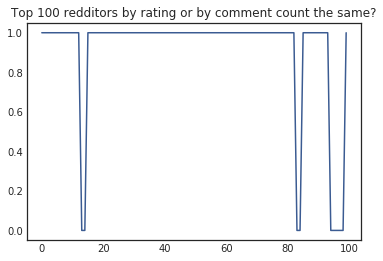

In [80]:
redditors_by_rating = redditorsDF.sort_values('rating', ascending = False).index.values
redditors_by_ncomments = redditorsDF.sort_values('n_comments', ascending = False).index.values

top_n = 100
plt.plot((redditors_by_rating == redditors_by_ncomments)[:top_n].astype(int), c = dark_colors[0])
plt.title('Top {} redditors by rating or by comment count the same?'.format(top_n))
print('The same members? {}'.format(set(redditors_by_rating[:top_n]) == set(redditors_by_ncomments[:top_n])))
plt.show()

The ordering may change but the top 100 has the same usernames.

In [81]:
for i in range(10):
     print ('{}: {} vs {}'.format(i + 1,
                                 redditors_by_rating[i],
                                 redditors_by_ncomments[i])
           )

1: Fulltergeist vs Fulltergeist
2: NotAikoYumi vs NotAikoYumi
3: Mr_Connie_Lingus69 vs Mr_Connie_Lingus69
4: Pasencia vs Pasencia
5: FecklessFool vs FecklessFool
6: Aeronautique_F vs Aeronautique_F
7: toshi04 vs toshi04
8: sakundes vs sakundes
9: cardboardbuddy vs cardboardbuddy
10: thenameisgsarci vs thenameisgsarci


Maybe we can also look at who has the highest average score. But in this case, users with only a few high scoring posts will dominate, even though they rarely participate in the RDs (mostly OANAs). 

In [82]:
redditorsDF['ave_score'] = redditorsDF['total_score'] / redditorsDF['n_comments']
redditorsDF.sort_values('ave_score', ascending=False)[['ave_score', 'n_comments']].head(10)

,ave_score,n_comments
author,,
BloodSweatTears18M,50.000000,1
noypikadiri,46.666667,3
thr0w4w4y456,43.500000,2
Nico-Nii_Nico-Chan,42.000000,1
Kung-Fu-Dugong,40.000000,1
NJNetsFan5152433,39.500000,2
namdrizal,36.000000,1
anticorruptionman,35.000000,1
alalako,35.000000,1


In [83]:
print('Half of the accounts totaled {} posts.'.format(redditorsDF['n_comments'].median()))

Half of the accounts totaled 6.0 posts.


It might be better to calculate a confidence interval for the mean score and take, say, the lower bound of that as as 'rating'? 

For authors with a lot of comments, the distribution looks positively skewed. 

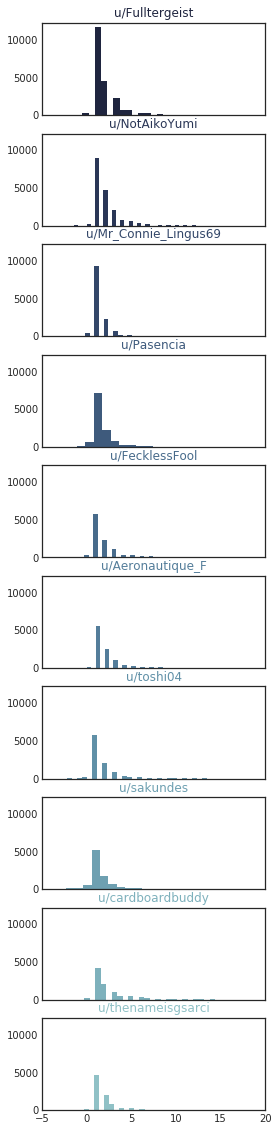

In [84]:
f, axarr = plt.subplots(10, 1, sharex=True, sharey=True, figsize=(4, 20))
plt.subplots_adjust(hspace=0.2, )

for ax, author, color in zip(axarr, most_comments_all_time, pal):
    ax.hist(commentsDF[commentsDF['author'] == author]['score'], bins = 100, color = color)
    ax.set_xlim(-5, 20)
    #ax.grid(False)dist = ss.t.ppf(0.975, df.shape[1]-1) * df.sem(axis=1)
    ax.set_title('u/{}'.format(author), 
                 {'fontsize': 12,
                  'horizontalalignment': 'center',
                  'color': color},
            )


Let's calculate the confidence interval for the mean of a user's score and limit to those with more than 30 posts.

In [85]:
ciDF = commentsDF[['author','score']].groupby('author').sem() 
ciDF.columns = ['sem']
ciDF['n'] = redditorsDF['n_comments']
ciDF['h'] = ss.t.ppf(0.975, ciDF['n']-1)
ciDF['mean'] = commentsDF[['author','score']].groupby('author').mean() 
ciDF ['lowerbound'] = ciDF['mean'] - (ciDF['h'] * ciDF['sem'])

redditorsDF['lb_score'] = ciDF['lowerbound']#.fillna(0) 
ciDF = ciDF[ciDF['n'] > 30]

In [86]:
ciDF.describe()

,sem,n,h,mean,lowerbound
count,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000
mean,0.224292,387.917650,1.987345,2.015763,1.567781
std,0.191601,959.179772,0.023147,0.683163,0.590462
min,0.000000,31.000000,1.960075,-7.666667,-10.887181
25%,0.104610,57.000000,1.967452,1.622686,1.287812
50%,0.171357,119.000000,1.980272,1.897436,1.528261
75%,0.276253,319.000000,2.003241,2.281250,1.819534
max,3.126425,21324.000000,2.042272,7.945652,5.065520


In [87]:
ciDF.sort_values('lowerbound', ascending=False).head(20)

,sem,n,h,mean,lowerbound
author,,,,,
blue_fluffy_pillows,1.449942,92,1.986377,7.945652,5.065520
ilongderanger,0.207320,1005,1.962330,5.268657,4.861826
unanatkumot,1.347570,39,2.024394,7.384615,4.656602
well_it_looks_like,0.782491,195,1.972268,6.071795,4.528514
snippetfactory,0.548795,35,2.032245,5.600000,4.484713
FashionPulisBot,0.194481,191,1.972528,4.816754,4.433135
joshuagapaz,0.743653,70,1.994945,5.885714,4.402167
NoneTheNarrator,1.106492,42,2.019541,6.571429,4.336823
SpideyTheOneAndOnly,0.808125,38,2.026192,5.684211,4.046794


Can we cluster participants into some interpretable groups?

In [88]:
###

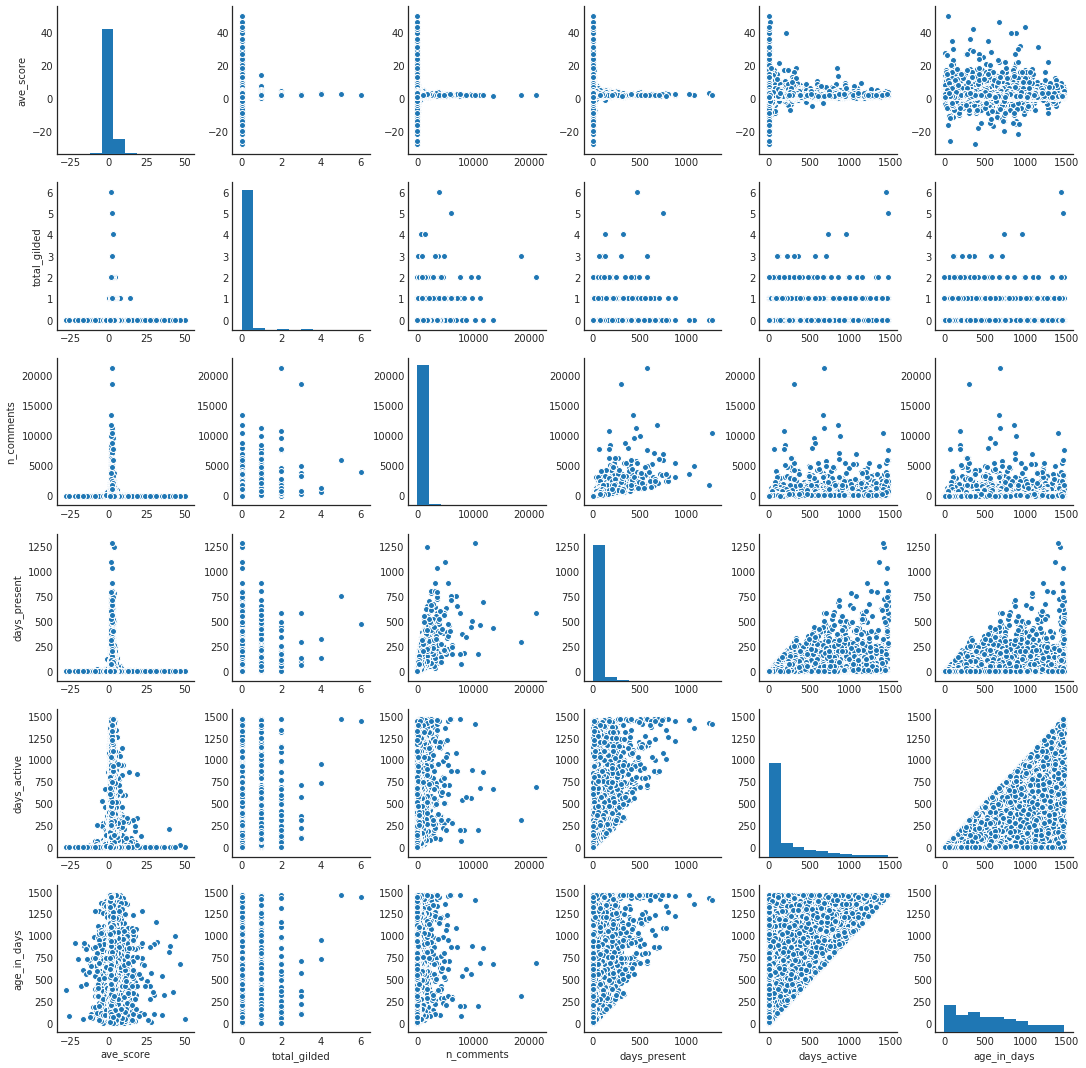

In [89]:
cols_to_pplot = ['ave_score', 
                 #'lb_score', 
                 'total_gilded', 'n_comments', 'days_present', 'days_active', 'age_in_days']
sns.pairplot(redditorsDF[cols_to_pplot]#.dropna()
            )

Notes from the pairplot:
* days_active vs ave score: most polarizing are OANAs?
* n_comments vs ave score: those who post a lot still mostly average 0.
* ave_score hist: RDs are more upvote-y than downvote-y
* ...

    

### To do:

* top words/word cloud

* topic modelling

* interactive plots for users to locate themselves



* can classify an RD top comment versus an r/PH submission (outside RD?)

* graph of who replies to whom the most - cliques? -- need to redownload but different form

* predict upvoted? predict gilded? maximize score? consider word count, posting time, sentiment



* detect a meme and create an ootl bot

* imitate top posters




Let's clean up the comments first. Tokenize, stem including words like 'akong', ... Do we have a POS tagger and lemmatizer for Tagalog? 

We also need to remove links and preserve emoticons if we like. How about the oft used sarcasm indicator '/s'? Luckily, there is a Reddit tokenizer on github we can start with. 

To do:

* haha hehe hihi hoho huhu
* /s support
* improved emoticon/textface preservation